In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras.layers import Dense, Dropout, LSTM,Conv1D, TimeDistributed, Flatten, SpatialDropout1D, GlobalAveragePooling1D, SimpleRNN, MaxPooling1D, GlobalMaxPooling1D, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, f1_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, precision_score, classification_report
from numpy import sqrt
from numpy import argmax
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
from numpy import genfromtxt

/Users/niall/opt/anaconda3/envs/DCUML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/niall/opt/anaconda3/envs/DCUML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/niall/opt/anaconda3/envs/DCUML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/niall/opt/anaconda3/envs/DCUML

In [2]:
def get_data():
    input_file = '/Users/niall/Documents/Cypress_Code/Data/AWGN/noise_data_awgn_snr_minusfive_final_large_big_new1.csv'
    my_data_flipped = genfromtxt(input_file, delimiter=',')

    new_data = np.delete(my_data_flipped, (0), axis=0)
    X2 = np.delete(new_data, (0,32), axis=1)
    Y2 = new_data[:,32]
    X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.25, random_state=42, shuffle=True)
    X_train = np.array(X_train).reshape((np.shape(X_train)[0], 1, np.shape(X_train)[1]))
    X_test = np.array(X_test).reshape((np.shape(X_test)[0], 1, np.shape(X_test)[1]))

    return X_train, X_test, y_train, y_test

In [3]:
flip_bit_data = get_data()

In [4]:
X_train = flip_bit_data[0]
X_test = flip_bit_data[1]
y_train = flip_bit_data[2]
y_test = flip_bit_data[3]

In [10]:
num_neurons = 31
num_features = 31

model_rnn = Sequential()
model_rnn.add(SimpleRNN(num_neurons, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, input_shape=(1, num_features)))
model_rnn.add(GlobalMaxPooling1D())
model_rnn.add(Dense(16, activation='sigmoid'))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(1, activation='sigmoid'))


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 1, 31)             1953      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 31)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 2,482
Trainable params: 2,482
Non-trainable params: 0
_________________________________________________________________


In [11]:
batch_size = 5
history_rnn = model_rnn.fit(X_train, y_train, 
                            batch_size=batch_size, 
                            epochs=5, 
                            validation_data=(X_test, y_test), 
                            callbacks=[rlrp],
                            verbose=1)

Train on 690000 samples, validate on 230000 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/5
690000/690000 [==============================] - 271s 392us/sample - loss: 0.2164 - acc: 0.9148 - val_loss: 0.1530 - val_acc: 0.9423
Epoch 2/5
690000/690000 [==============================] - 264s 382us/sample - loss: 0.2077 - acc: 0.9189 - val_loss: 0.1525 - val_acc: 0.9427
Epoch 3/5
690000/690000 [==============================] - 264s 382us/sample - loss: 0.2072 - acc: 0.9191 - val_loss: 0.1499 - val_acc: 0.9433
Epoch 4/5
690000/690000 [==============================] - 265s 384us/sample - loss: 0.2060 - acc: 0.9198 - val_loss: 0.1504 - val_acc: 0.9431
Epoch 5/5
690000/690000 [==============================] - 276s 400us/sample - loss: 0.2053 - acc: 0.9205 - val_loss: 0.1520 - val_acc: 0.9425


230000/230000 [==============================] - 5s 23us/sample - loss: 0.1520 - acc: 0.9425
Test Loss:  0.15198459431010744
Test Accuracy 0.9424826
dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


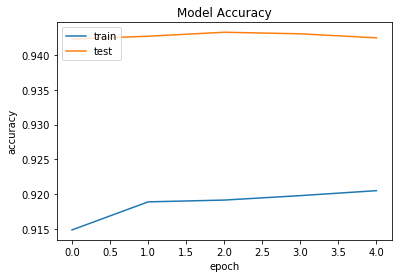

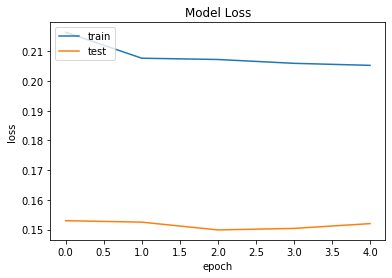

In [12]:
score = model_rnn.evaluate(X_test, y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])

print(history_rnn.history.keys())

plt.plot(history_rnn.history['acc'])
plt.plot(history_rnn.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
json = model_rnn.to_json()
with open("/Users/niall/Documents/Cypress_Code/Models/RNN/AWGN/model_one_rnn_awgn_minus5.json", "w") as file:
    file.write(json)
model_rnn.save_weights("/Users/niall/Documents/Cypress_Code/Models/RNN/AWGN/model_one_rnn_awgn_minus5.h5")
print("Saved model to disc")

Saved model to disc


In [5]:
# Load the model of interest
json_file = open('/Users/niall/Documents/Cypress_Code/Models/RNN/AWGN/model_one_rnn_awgn_minus5.json', 'r')
json = json_file.read()
json_file.close()
model_avg_from_disc = model_from_json(json)
model_avg_from_disc.load_weights("/Users/niall/Documents/Cypress_Code/Models/RNN/AWGN/model_one_rnn_awgn_minus5.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
y_preds_rnn = model_avg_from_disc.predict(X_test, batch_size=1)

In [18]:
pred_avg = pd.DataFrame(y_preds_rnn, columns =['Y_pred']) 
pred_avg['Label'] = y_test

In [19]:
pred_avg.to_csv('/Users/niall/Documents/Cypress_Code/Predictions/RNN/AWGN/model_one_rnn_awgn_minus5.csv', index = False)

In [20]:
yhat = model_avg_from_disc.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, yhat)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.565269, G-Mean=0.944


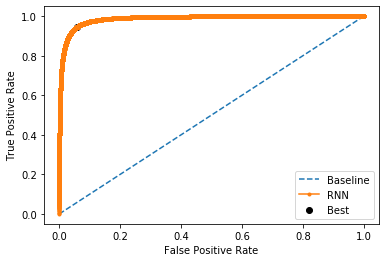

In [21]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='Baseline')
plt.plot(fpr, tpr, marker='.', label='RNN')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.savefig('/Users/niall/Documents/Cypress_Code/Plots/Matlab_awgn/RNN_ROC.jpg')
plt.show()

In [23]:
auc = roc_auc_score(y_test, yhat)
print('ROC AUC=%.3f' % (auc))

ROC AUC=0.987


In [6]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
    
yhat_new = model_avg_from_disc.predict_classes(X_test)
metrics(yhat_new, y_test)

F1-score:  0.9421867557020054
Precision:  0.9586557102964979
Recall:  0.9262740919597515
Acuracy:  0.9424826086956521
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.96      0.94    113623
           1       0.96      0.93      0.94    116377

    accuracy                           0.94    230000
   macro avg       0.94      0.94      0.94    230000
weighted avg       0.94      0.94      0.94    230000

